# Final Project 
#### Group Members :- Aditya Kesari, Fiona Wang, Dhruv Rana

---

## 0. Import 

In [16]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as Image_display

from skimage.io import imread

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms, models

from keras.models import Model
from keras.applications import vgg16
from keras.layers import Input
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2DTranspose, Activation, Concatenate, Conv2D, BatchNormalization

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


## 1. Label Colors

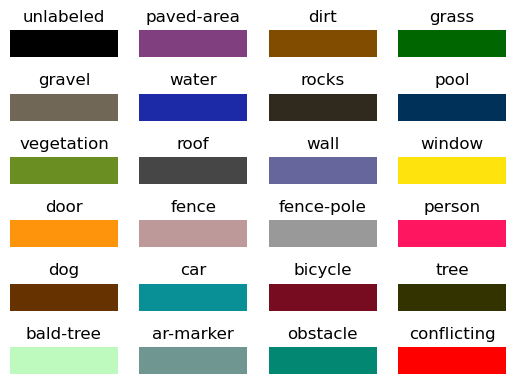

In [17]:
label_map = pd.read_csv("./archive/class_dict_seg.csv")

for index,label in enumerate(label_map["name"]):
    plt.subplot(6,4,index+1)
    (R,G,B) = label_map.iloc[index][1:]
    color = np.array([[[R,G,B],[R,G,B],[R,G,B],[R,G,B]]]) # need a MxNx4 array to use imshow to plot colors
    plt.imshow(color)
    plt.title(label)
    plt.axis("off")

plt.show()

num_classes = label_map["name"].size

## 2. Examine Data

In [18]:
image_dir = "./archive/dataset/semantic_drone_dataset/original_images/"
mask_dir = "./archive/RGB_color_image_masks/RGB_color_image_masks/"


image_path = np.array(sorted(glob.glob(image_dir+"*.jpg")))
mask_path = np.array(sorted(glob.glob(mask_dir+"*.png")))

print("Total Images in dataset: ", len(image_path))

Total Images in dataset:  400


In [19]:
id_num = 300

img = Image.open(image_path[id_num])
mask = Image.open(mask_path[id_num])

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

IMG_HEIGHT,IMG_WIDTH,IMG_CH = np.asarray(img).shape

Image Size (4000, 6000, 3)
Mask Size (4000, 6000, 3)


## 3. Examine Mask

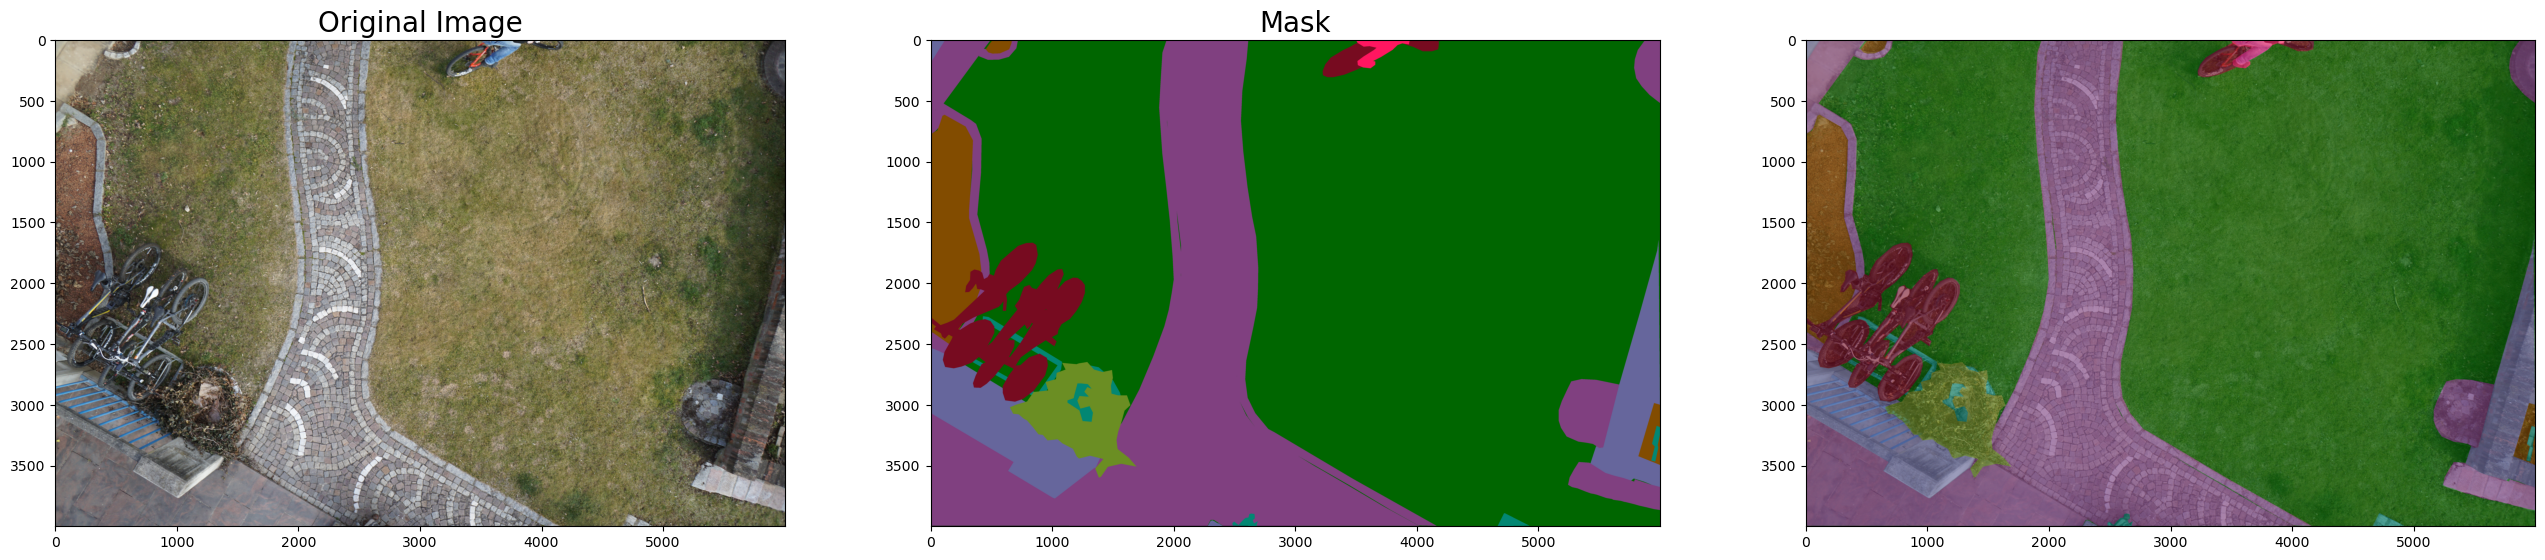

In [20]:
fig, axs = plt.subplots(1,3,figsize=(32,32))
axs[0].imshow(img)
axs[0].set_title("Original Image",size=20)

axs[1].imshow(mask)
axs[1].set_title("Mask",size=20)

axs[2].imshow(img)
axs[2].imshow(mask, alpha=0.6)
axs[2].set_title("Mask Applied",size=20)

plt.title("")
plt.show()

## Hyperparameters

In [21]:
# Percentage of how to split the dataset
TRAIN_SPLIT = 0.9
TEST_SPLIT = 0.1

# Amount of images in one batch
BATCH_SIZE = 3
SHUFFLE = True

# If the model cannot run increase the factor amount as the images are very large (4000x6000)
factor = 2.5
RESIZE_HEIGHT = int(IMG_HEIGHT/factor)
RESIZE_WIDTH = int(IMG_WIDTH/factor)

# For pre-trained model U-net that uses MobileNet fro encoder

EPOCHS = 40

## 4.Split &  Load Data

#### i) Make Dataset

In [22]:
# Need to make a custom Dataset as no built function achives the functinaly of having image as a label
class SegmentationImageDataset(Dataset):
    def __init__ (self,img_path,mask_path,transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
    
    def __len__ (self):
        return len(self.img_path)

    def __getitem__(self, index:int):
        img_ID = image_path[index]
        mask_ID = mask_path[index]

        X,Y = imread(img_ID), imread(mask_ID)

        if self.transform is not None :
            X,Y = self.transform(X),self.transform(Y)
        
        X,Y = torch.from_numpy(np.asarray(X)), torch.from_numpy(np.asarray(Y))

        return X,Y

In [23]:
data_transform = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Resize((RESIZE_HEIGHT, RESIZE_WIDTH)),
])

dataset = SegmentationImageDataset(image_path,mask_path,transform=data_transform)
DATASET_SIZE = len(dataset)

#### ii) Split Data

In [24]:
train_data, test_data = random_split(dataset, [ int(TRAIN_SPLIT*DATASET_SIZE) , int(TEST_SPLIT*DATASET_SIZE)])

#### iii) Load Data

In [25]:
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

## 5. Performance Metrics

## 6. Display Function 

In [26]:
def display_img_mask_applied(img,mask,title):
    fig, axs = plt.subplots(1,3,figsize=(32,32))
    axs[0].imshow(img)
    axs[0].set_title("Original Image",size=20)

    axs[1].imshow(mask)
    axs[1].set_title("Mask",size=20)

    axs[2].imshow(img)
    axs[2].imshow(mask, alpha=0.6)
    axs[2].set_title("Mask Applied",size=20)

    plt.title(title)
    plt.show()

## 6. Models

### Transfer Learning on Pre-Built Model  

#### i) Examine Model

In [27]:
torch.cuda.empty_cache()
# We first looked at all models provided by keras, and found the perfect balance in VGG
# VGG perfomrs really well and is not that dense, allowing us to easily modify and understand the new model.
import torchinfo
from torchsummary import summary
#input_shape = (RESIZE_HEIGHT,RESIZE_WIDTH,IMG_CH)
#VGG16 = vgg16.VGG16(include_top=False,input_shape=input_shape,weights="imagenet")
#VGG16.summary()
input_shape_mod = (IMG_CH,RESIZE_HEIGHT,RESIZE_WIDTH)
input_shape = (RESIZE_HEIGHT,RESIZE_WIDTH,IMG_CH)

VGG16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(DEVICE)

summary(VGG16,(IMG_CH, IMG_HEIGHT, IMG_WIDTH))

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.45 GiB (GPU 0; 8.00 GiB total capacity; 2.11 GiB already allocated; 4.92 GiB free; 2.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### ii) Decide Layer(s) to freeze

In [ ]:
# We dont have a lot of data only 400 images, we could have tried to generate images
# However, to compensate for this we will freeze the weight of few blocks in the model
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in VGG16.layers]
layers_df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
layers_df

#### iii) Decoder Block

In [ ]:
# Up till now we have the encoder part of our model, but we need a decoder that takes us back to the input shape
# A decoder block up-convulations the previous layer's ouput, connects it with a skip , and performs regular conv on the output 

def conv_block (inputs,num_feature):
    """" 2 conv per block"""
    x = Conv2D(num_feature,kernel_size=3,strides=1,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_feature,kernel_size=3,strides=1,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs,skip_feature,num_feature):

    """ up-conv """
    x = Conv2DTranspose(num_feature,kernel_size=3,strides=2,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    

    """ Skip Connect """
    x = Concatenate()([x,skip_feature])


    """ Conv """
    x = conv_block(x,num_feature)

    return x

#### iv) Build Model

In [ ]:
def Unet_VGG(input_shape,num_classes):
    """ Inputs """
    input = Input(input_shape)

    """ Encoders """
    """ Pre-Trained VGG16 model w/ layers frozen """
    VGG16 = vgg16.VGG16(include_top=False,input_tensor=input)

    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False

    """ Bridge """

    vgg_last_layer = VGG16.output # 512

    """" Decoders """
    """ 1st Decoder --> connects with VGG block 5 before pooling"""
    d1 = decoder_block(vgg_last_layer,VGG16.get_layer("block5_conv3").output,512)

    """ 2nd Decoder --> connects with VGG block 4 before pooling"""
    d2 = decoder_block(d1,VGG16.get_layer("block4_conv3").output,512)

    """ 3rd Decoder --> connects with VGG block 3 before pooling"""
    d3 = decoder_block(d2,VGG16.get_layer("block3_conv3").output,256)

    """ 4th Decoder --> connects with VGG block 2 before pooling"""
    d4 = decoder_block(d3,VGG16.get_layer("block2_conv2").output,128)

    """ 4th Decoder --> connects with VGG block 1 before pooling"""
    d5 = decoder_block(d4,VGG16.get_layer("block1_conv2").output,64)

    """ Outputs """
    output = Conv2D(num_classes,kernel_size=1,padding="same",activation="softmax")(d5)
    
    model = Model(input,output)

    return model


model = Unet_VGG(input_shape,num_classes)

#### v) Visulaize model

In [ ]:
model.summary()

In [ ]:
plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)
Image_display(retina=True, filename='model.png')

#### vi) Test Model w/o Training

In [ ]:
model = model.eval()

for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break

img = inputs[4]
plt.imshow(img, cmap='Greys')
plt.show()

with torch.no_grad():
    prediction = model(inputs.to(DEVICE))

##### vii) Train Model

##### viii) Test Model w/ Training